# ElectroMKM class import and object instantiation

In [1]:
import sys
sys.path.insert(0, "../../electromkm/") 
from electromkm import electroMKM

The demo system deal with the Hydrogen Evolution Reaction (HER) with random values.

In [2]:
model = electroMKM('HER',
                   'rm.mkm', 
                   'g.mkm', 
                    t_ref=298)

In [3]:
test = [1, 2, 3, 4]


In [4]:
test[2:]

[3, 4]

# Model exploration


To investigate the characteristics of the system under study, several attributes can be easily inspected to check general information like number of elementary reactions, energetics, reaction network, etc.

In [5]:
print(model)

System: HER
2H(e) -> H2
Number of global reactions: 1
Number of elementary reactions: 2
Number of surface species: 2
Number of gas species: 1



### Defined species in the system

N.B. H(e) is used to define H+ + e-.

In [6]:
model.v_f.shape == model.v_matrix.shape

False

In [7]:
model.NC_sur

2

In [8]:
model.NC_gas

1

In [9]:
model.species_tot

['*', 'H*', 'H(e)', 'H2(g)']

### Visualize Gibbs energetics of the system

Reaction types: 'ads'=adsorption
                'des'=desorption
                'sur'=surface reaction. 
The suffix "+e" means that that elementary reaction is a charge-transfer step.

In [10]:
model.df_gibbs

,,DGR / eV,DG barrier / eV,DG reverse barrier / eV
R1,sur+a_e,-0.03,0.57,0.6
R2,des,0.05,0.05,0.0


### Stoichiometric matrix of the reaction network

In [11]:
model.df_system

,R1,R2
,sur+a_e,des
species,,
*,-1,2
H*,1,-2
H(e),-1,0
H2(g),0,1


### Stoichiometric vector of the global reactions

In [12]:
model.species_tot

['*', 'H*', 'H(e)', 'H2(g)']

In [13]:
model.v_global

array([[ 0.],
       [ 0.],
       [-2.],
       [ 1.]])

In [14]:
model.stoich_numbers

array([[2.],
       [1.]])

model.stoich_numbers tells us that the first elementary reaction must be multiplied by two and summed up to the second one in order to get the global reaction. This is useful for checking the thermodynamic consistency of the developed models.

# Microkinetic runs and Tafel plot

Up to now, it is possible to run steady state runs via the electroMKM.kinetic_run() function.
The main inputs that must be provided are the applied overpotential and the pH of the electrolyte solution.
The output of the function is a Python dictionary containing information related to the performed simulation.

In [15]:
model.set_ODE_params(t_final=10000)

Final integration time = 10000s
Relative tolerance = 1e-12
Absolute tolerance = 1e-64


'Changed ODE solver parameters.'

In [16]:
model.dh_barrier

array([0.75, 0.  ])

### Steady state simulation

In [17]:
import numpy as np
exp = model.kinetic_run(-0.2, 7, initial_sur_coverage=[1,0.0])
#exp = model.kinetic_run(-0.2, 7,jac=True)

HER: Microkinetic run
Overpotential = -0.2V vs SHE    pH = 7
Overpotential = 0.21299999999999997V vs RHE
Temperature = 298.0K    Pressure = 1.0bar

HER Current density: 4.41e-01 mA cm-2
HER Selectivity: 100.00%
Most Abundant Surface Intermediate: H* Coverage: 72.58% 
CPU time: 1.32 s


/home/rseemakurthi/miniconda3/envs/jupyter/lib/python3.6/site-packages/scipy/integrate/_ivp/bdf.py:218: LinAlgWarning: Diagonal number 2 is exactly zero. Singular matrix.
  return lu_factor(A, overwrite_a=True)


The first check should be about the reaching of the steady state. This means that all the derivatives in the ODE must equal to zero. These values can be easily visualized with the key 'ddt':

(0.0, 1e-11)

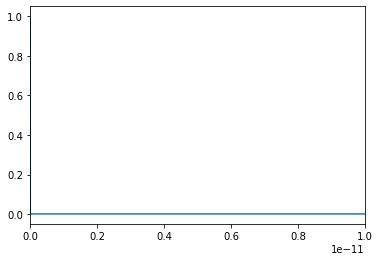

In [57]:
import matplotlib.pyplot as plt
time = exp['solver'].t
y = exp['solver'].y[0,:]
plt.plot(time, y)

Once steady state conditions have been checked, the solution can be easily analyzed. the main output consists of steady state surface coverage and reaction rate in term of current density.

In [8]:
exp['theta']

{'*': 0.0011931038441200543, 'H*': 0.9988068961558821}

In [9]:
exp['MASI']

{'H*': 0.9988068961558821}

Negative current density means reduction is occurring, while positive values means that reaction is evolving in the opposite direction. Values of current density are stored in mA cm-2.

In [10]:
exp['j_HER']

3.035767734370702

### Tafel plot

In [7]:
import numpy as np
n = np.array([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
print(n)

[-0.3 -0.2 -0.1  0.   0.1  0.2  0.3]


In [8]:
model.tafel_plot("HER", n ,7, jac=True)

HER: Tafel slope experiment for HER
Temperature: 298.0 K    Pressure: 1 bar    pH: 7



TypeError: object of type 'bool' has no len()

### Check for the analytical Jacobian matrix

In order to check if the implemented analytical Jacobian is correct or not, we run the same simulation with and without the analytical Jacobian: If the solutions are the same, the Jacobian is correct. If not, it means that the wrong Jacobian drives the system away from the correct solution. 

#### Simulation without analytical Jacobian

In [21]:
exp1 = model.kinetic_run(-0.1, 7, jac=False)

HER: Microkinetic run
Overpotential = -0.1V vs SHE    pH = 7
Temperature = 298.0K    Pressure = 1.0bar

HER Current density: -7.32e-05 mA cm-2
HER Selectivity: 100.00%
Most Abundant Surface Intermediate: * Coverage: 100.00% 
CPU time: 9.09 s


#### Simulation with analytical Jacobian

In [23]:
exp2 = model.kinetic_run(-0.1, 7, jac=True)

HER: Microkinetic run
Overpotential = -0.1V vs SHE    pH = 7
Temperature = 298.0K    Pressure = 1.0bar

HER Current density: -7.32e-05 mA cm-2
HER Selectivity: 100.00%
Most Abundant Surface Intermediate: * Coverage: 100.00% 
CPU time: 0.13 s


Observe the difference in the CPU time required to integrate the system without and with the Jacobian!

In [7]:
import numpy as np
model.degree_of_rate_control("HER", "R1", -0.2, 7, gas_composition=np.array([1]))

HER: DRC analysis for elementary reaction R1 wrt HER reaction
Temperature = 298.0K    Pressure = 1.0bar
Gas composition: H2=100.0%  



KeyboardInterrupt: 

In [15]:
model.NC_gas 

1